In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

In [2]:
import sys
sys.path.append('./test')
from snowflake.snowpark.session import Session
from parameters import CONNECTION_PARAMETERS

### Connect to Snowflake

In [3]:
session = Session.builder.configs(CONNECTION_PARAMETERS).create()
session.sql("alter session set enable_python_udf=true").collect()

[Row('Statement executed successfully.')]

### Upload a CSV file to Snowflake and read it into dataframe

In [4]:
# we will have a public API for uploading files at session level soon
session.conn.upload_file("./titanic/train.csv", stage_location=session.getSessionStage(),
                         dest_prefix='titanic', compress_data=False, overwrite=True)

In [5]:
from snowflake.snowpark.types.sf_types import IntegerType, StringType, FloatType, StructType, StructField
train_csv_schema = StructType([StructField("PassengerId", IntegerType()),
                             StructField("Survived", IntegerType()),
                             StructField("Pclass", IntegerType()),
                             StructField("Name", StringType()),
                             StructField("Sex", StringType()),
                             StructField("Age", IntegerType()),
                             StructField("SibSp", IntegerType()),
                             StructField("Parch", IntegerType()),
                             StructField("Ticket", StringType()),
                             StructField("Fare", FloatType()),
                             StructField("Cabin", StringType()),
                             StructField("Embarked", StringType())])

options = {"SKIP_HEADER": 1, "FIELD_OPTIONALLY_ENCLOSED_BY": '"'}

                        
train_file_on_stage = f"{session.getSessionStage()}/titanic/train.csv" 
df_train = session.read.options(options).schema(train_csv_schema).csv(train_file_on_stage)             

In [6]:
df_train.show()
df_train.count()

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"PASSENGERID"  |"SURVIVED"  |"PCLASS"  |"NAME"                                              |"SEX"   |"AGE"  |"SIBSP"  |"PARCH"  |"TICKET"          |"FARE"   |"CABIN"  |"EMBARKED"  |
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|1              |0           |3         |Braund, Mr. Owen Harris                             |male    |22     |1        |0        |A/5 21171         |7.25     |NULL     |S           |
|2              |1           |1         |Cumings, Mrs. John Bradley (Florence Briggs Tha...  |female  |38     |1        |0        |PC 17599          |71.2833  |C85      |C           |
|3              |1           |3         |Heikkinen, Miss. Laina                 

891

### Data cleaning

In [7]:
from snowflake.snowpark.functions import sum as sum_, col

df_train.agg([sum_(col(name).is_null().cast(IntegerType())) for name in df_train.columns]).toDF(df_train.columns).show()

---------------------------------------------------------------------------------------------------------------------------------
|"PASSENGERID"  |"SURVIVED"  |"PCLASS"  |"NAME"  |"SEX"  |"AGE"  |"SIBSP"  |"PARCH"  |"TICKET"  |"FARE"  |"CABIN"  |"EMBARKED"  |
---------------------------------------------------------------------------------------------------------------------------------
|0              |0           |0         |0       |0      |177    |0        |0        |0         |0       |687      |2           |
---------------------------------------------------------------------------------------------------------------------------------



In [8]:
from snowflake.snowpark.functions import mode, median, iff, call_builtin

train_age_median = df_train.select(median("age")).collect()[0][0]
train_embarked_mode = df_train.select(mode("embarked")).collect()[0][0]

columns_to_drop = ["passengerid", "name", "ticket", "cabin"]

# we will have a public API for filling null/nan value soon
df_train_cleaned = df_train.withColumn("age_cleaned", call_builtin("iff", col("age").is_null(), train_age_median, col("age"))) \
                           .withColumn("embarked_cleaned", call_builtin("iff", col("embarked").is_null(),train_embarked_mode, col("embarked"))) \
                           .drop("age", "embarked", *columns_to_drop)

In [9]:
df_train_cleaned.show()

-------------------------------------------------------------------------------------------------------------
|"SURVIVED"  |"PCLASS"  |"SEX"   |"SIBSP"  |"PARCH"  |"FARE"   |"AGE_CLEANED"          |"EMBARKED_CLEANED"  |
-------------------------------------------------------------------------------------------------------------
|0           |3         |male    |1        |0        |7.25     |22.000000000000000000  |S                   |
|1           |1         |female  |1        |0        |71.2833  |38.000000000000000000  |C                   |
|1           |3         |female  |0        |0        |7.925    |26.000000000000000000  |S                   |
|1           |1         |female  |1        |0        |53.1     |35.000000000000000000  |S                   |
|0           |3         |male    |0        |0        |8.05     |35.000000000000000000  |S                   |
|0           |3         |male    |0        |0        |8.4583   |28.000000000000000000  |Q                   |
|0        

### Feature engineering

In [10]:
from snowflake.snowpark.functions import min as min_, max as max_, udf

train_age_min = df_train_cleaned.select(min_("age_cleaned")).collect()[0][0]
train_age_max = df_train_cleaned.select(max_("age_cleaned")).collect()[0][0]
train_fare_min = df_train_cleaned.select(min_("fare")).collect()[0][0]
train_fare_max = df_train_cleaned.select(max_("fare")).collect()[0][0]


df_train_augmented = df_train_cleaned.withColumn("family_size", df_train_cleaned['sibsp'] + df_train_cleaned['parch'] + 1)
df_train_augmented = df_train_augmented.withColumn("is_alone", (df_train_augmented["family_size"] > 1).cast(IntegerType())) \
                                       .withColumn("age_bin", call_builtin("width_bucket", col("age_cleaned"), train_age_min, train_age_max, 5)) \
                                       .withColumn("fare_bin", call_builtin("width_bucket", col("fare"), train_fare_min, train_fare_max, 4)) \
                                       .drop("sibsp", "parch", "fare", "age_cleaned")
df_train_augmented.show()

-------------------------------------------------------------------------------------------------------------
|"SURVIVED"  |"PCLASS"  |"SEX"   |"EMBARKED_CLEANED"  |"FAMILY_SIZE"  |"IS_ALONE"  |"AGE_BIN"  |"FARE_BIN"  |
-------------------------------------------------------------------------------------------------------------
|0           |3         |male    |S                   |2              |1           |2          |1           |
|1           |1         |female  |C                   |2              |1           |3          |1           |
|1           |3         |female  |S                   |1              |0           |2          |1           |
|1           |1         |female  |S                   |2              |1           |3          |1           |
|0           |3         |male    |S                   |1              |0           |3          |1           |
|0           |3         |male    |Q                   |1              |0           |2          |1           |
|0        

### Encode label
This part can be accomplished by creating a UDF with `sklearn.preprocessing.LabelEncoder`once we have `flatten` table function (under development).

In [11]:
df_train_cleaned.select("EMBARKED_CLEANED").distinct().show()

----------------------
|"EMBARKED_CLEANED"  |
----------------------
|S                   |
|C                   |
|Q                   |
----------------------



In [12]:
@udf 
def encode_embarked(e: str) -> int:
    if e == "S":
        return 0
    elif e == "C":
        return 1
    else:
        return 2
    
df_train_augmented = df_train_augmented.withColumn("embarked_encoded", encode_embarked("EMBARKED_CLEANED"))

In [13]:
df_train_augmented = df_train_augmented.withColumn("sex_encoded", call_builtin("iff", col("sex") == "male", 0, 1)) \
                                       .withColumn("age_encoded", col("age_bin") - 1) \
                                       .withColumn("fare_encoded", col("fare_bin") - 1)
df_train_augmented = df_train_augmented.select("survived", "pclass", "family_size", "is_alone", "embarked_encoded",
                                               "sex_encoded", "age_encoded", "fare_encoded")
df_train_augmented.show()

----------------------------------------------------------------------------------------------------------------------------
|"SURVIVED"  |"PCLASS"  |"FAMILY_SIZE"  |"IS_ALONE"  |"EMBARKED_ENCODED"  |"SEX_ENCODED"  |"AGE_ENCODED"  |"FARE_ENCODED"  |
----------------------------------------------------------------------------------------------------------------------------
|0           |3         |2              |1           |0                   |0              |1              |0               |
|1           |1         |2              |1           |1                   |1              |2              |0               |
|1           |3         |1              |0           |0                   |1              |1              |0               |
|1           |1         |2              |1           |0                   |1              |2              |0               |
|0           |3         |1              |0           |0                   |0              |2              |0               |


### Save to a table in Snowflake

In [14]:
df_train_augmented.write.saveAsTable("titanic")
df = session.table("titanic")
df.show()

----------------------------------------------------------------------------------------------------------------------------
|"SURVIVED"  |"PCLASS"  |"FAMILY_SIZE"  |"IS_ALONE"  |"EMBARKED_ENCODED"  |"SEX_ENCODED"  |"AGE_ENCODED"  |"FARE_ENCODED"  |
----------------------------------------------------------------------------------------------------------------------------
|0           |3         |2              |1           |0                   |0              |1              |0               |
|1           |1         |2              |1           |1                   |1              |2              |0               |
|1           |3         |1              |0           |0                   |1              |1              |0               |
|1           |1         |2              |1           |0                   |1              |2              |0               |
|0           |3         |1              |0           |0                   |0              |2              |0               |


### Train and Validate ML models 

In [15]:
from snowflake.snowpark.types.sf_types import ArrayType, MapType
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier


def train_and_validate(model_class, X, y, cv=5):
    acc_train, acc_val = [], []
    for i in range(cv):
        model = model_class()
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=i+1)
        model.fit(X_train, y_train)
        acc_train.append(model.score(X_train, y_train))
        acc_val.append(model.score(X_val, y_val))
    return sum(acc_train) / cv, sum(acc_val) / cv


def run_models(*data):
    y = np.array(data[0])
    X = np.column_stack(data[1:])
    
    models = {"lr": LogisticRegression,
              "perceptron": Perceptron,
              "svm": SVC,
              "xgboost": XGBClassifier,
              "random_forest": RandomForestClassifier,
              "knn": KNeighborsClassifier}
    
    return {k: train_and_validate(v, X, y) for k, v in models.items()}


run_models_udf = udf(run_models, return_type=MapType(StringType(), ArrayType(FloatType())), input_types=[ArrayType(IntegerType())] * len(df.columns))

In [16]:
from snowflake.snowpark.functions import array_agg

res = eval(df.select(run_models_udf(*[array_agg(col(name)) for name in df.columns])).collect()[0][0])
res

{'knn': [0.8421348314606742, 0.7921787709497208],
 'lr': [0.8044943820224718, 0.7955307262569834],
 'perceptron': [0.7362359550561798, 0.7061452513966481],
 'random_forest': [0.8693820224719101, 0.794413407821229],
 'svm': [0.8300561797752808, 0.8178770949720671],
 'xgboost': [0.8643258426966292, 0.8]}

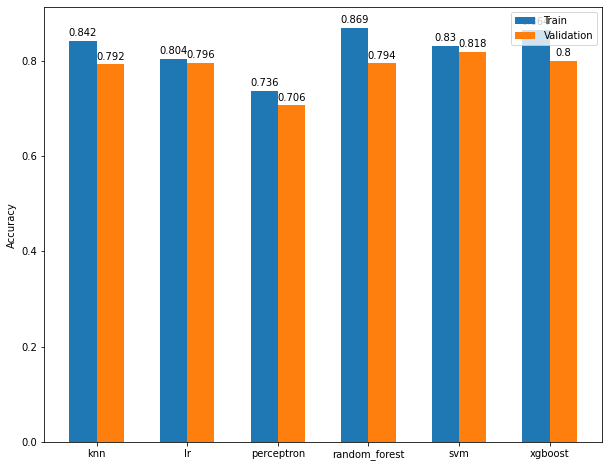

In [17]:
import matplotlib.pyplot as plt

model_class, acc_train, acc_val = [], [], []
for k, v in res.items():
    model_class.append(k)
    acc_train.append(round(v[0], 3))
    acc_val.append(round(v[1], 3))

    
x = np.arange(len(model_class))
width = 0.3 


plt.figure(figsize=(10, 8))
ax = plt.gca()
rects1 = ax.bar(x - width/2, acc_train, width, label='Train')
rects2 = ax.bar(x + width/2, acc_val, width, label='Validation')

ax.set_ylabel('Accuracy')
ax.set_xticks(x)
ax.set_xticklabels(model_class)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

plt.show()

----------------------------------------------------------

In [18]:
session.sql("drop table if exists titanic").collect()
session.close()